# Clasificación

El modelo de regresión lineal supone que la variable respuesta $Y$ es _**cuantitativa**_. Sin embargo, en muchas situaciones, dicha variable es _**cualitativa**_. Las variables cualitativas también reciben el nombre de _**categóricas**_; estos dos términos serán usados indistintamente. En este capítulo, se estudiarán distintos enfoques para predecir las respuestas cualitativas, un proceso que se conoce como _**clasificación**_. La predicción de la respuesta cualitativa para una observación es denominada clasificación de la observación, ya que implica asignar la observación a una categoría o clase. Por otra parte, generalmente los métodos utilizados para la clasificación predicen primero la probabilidad de cada una de las categorías de la variable cualitativa, como base para hacer la clasificación. En este sentido también se comportan como métodos de regresión.

Existen muchas técnicas de clasificación, o clasificadores, que se usan para predecir una respuesta cualitativa. En este capítulo se analizan algunos de los clasificadores más utilizados: _regresión logística , análisis discriminante y los K-vecinos más cercanos entre otros_.

Así como en el ajuste de una regresión, en el ajuste de una clasificación se cuenta con un conjunto de observaciones de entrenamiento $(x_1, y_1), ... , (x_n, y_n)$ que podemos usar para construir un clasificador. Queremos que nuestro clasificador funcione bien no sólo en los datos de entrenamiento, sino también en las observaciones de prueba que no fueron usadas para entrenar al clasificador.

A continuación se ilustrará el concepto de clasificación utilizando el conjunto de datos llamado **Default**. Estamos interesados en predecir si un individuo incumplirá el pago de su tarjeta de crédito (_caerá en default_), sobre la base del ingreso anual y el saldo mensual de la tarjeta de crédito. El conjunto de datos se muestra en la siguiente figura; se han graficado los **_ingresos_** anuales y el **_saldo_** mensual de la tarjeta de crédito para un subconjunto de 10,000 personas. El panel izquierdo de la figura muestra en color naranja a las personas que incumplieron con el pago en un mes, y en azul las que cumplieron. (_La tasa general de morosidad es de alrededor del 3%, por lo que hemos graficado sólo una parte de los individuos que no cayeron en default_.)

In [1]:
# Cargamos las respectivas librerias
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

# Desde R, se ha exportado el conjunto de datos a Excel del paquete 'ISLR'
df = pd.read_excel('data/Default.xlsx')
df.head()

  default student      balance        income
1      No      No   729.526495  44361.625074
2      No     Yes   817.180407  12106.134700
3      No      No  1073.549164  31767.138947
4      No      No   529.250605  35704.493935
5      No      No   785.655883  38463.495879

In [2]:
# Como las dos primeras variables son categóricas como se puede observar, 
# debemos transformarlas de tal forma que las entienda el modelo a utilizar. 
# Por ser variables binarias o con solo dos atributos Yes/No, se puede hacer lo siguiente:
# se utiliza la función factorize() que retorna dos objetos, un arreglo de etiquetas y un arreglo de valores únicos
# Esta es una de las formas mas básicas o faciles de incluir variables cualitativas en el modelo.
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

  default student      balance        income  default2  student2
1      No      No   729.526495  44361.625074         0         0
2      No     Yes   817.180407  12106.134700         0         1
3      No      No  1073.549164  31767.138947         0         0

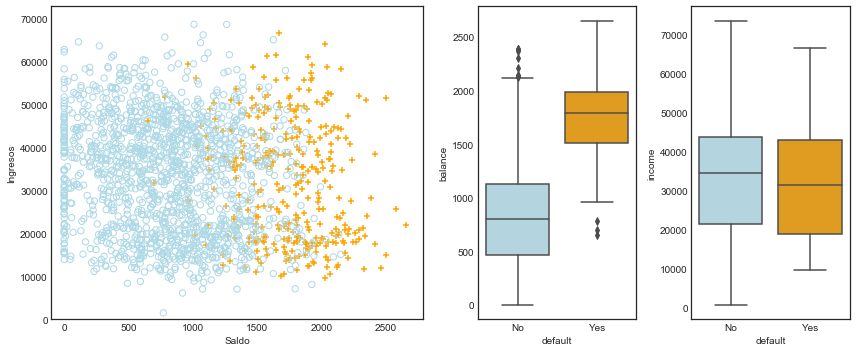

In [3]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='none')

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Ingresos')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Saldo')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

Parece que las personas que incumplieron tendían a tener mayores saldos en las tarjetas de crédito que los que no. En el panel derecho de la figura, se muestran dos pares de gráficos de caja (boxplots). El primer par muestra la distribución del saldo para cada una de las categorías de la variable binaria de default; el segundo es un gráfico similar para los ingresos. En este capítulo, se aprenderá a construir un modelo para predecir el default ($Y$) para cualquier valor dado del saldo ($X_1$) y el ingreso ($X_2$).

### ¿Porqué no usar Regresión Lineal?
_¿Porqué no es apropiada la regresión lineal en el caso de una respuesta cualitativa?_
Por desgracia, en general **no hay forma natural de convertir una variable de respuesta cualitativa con más de dos niveles en una respuesta cuantitativa que sea adecuada para la regresión lineal**.

En el caso binario no es difícil demostrar que incluso si volteamos la codificación anterior, la regresión lineal producirá las mismas predicciones finales.

Para una respuesta binaria con una codificación 0/1 como antes, la regresión por mínimos cuadrados tiene sentido; se puede demostrar que la estimación $X\hat \beta$   obtenida por medio de la regresión lineal es de hecho una estimación de la Pr(sobredosis de fármaco|X). Sin embargo, el uso de la regresión lineal puede producir algunas estimaciones por fuera del intervalo [0, 1], por lo que resulta difícil interpretarlas como probabilidades. Sin embargo, las predicciones proporcionan un ordenamiento y pueden interpretarse como estimaciones aproximadas de probabilidad. Curiosamente, resulta que las clasificaciones que obtenemos si usamos la regresión lineal para predecir una respuesta binaria serán las mismas que las obtenidas para el procedimiento de análisis discriminante lineal (LDA) que se discutirá más adelante.

Sin embargo, el enfoque de la variable ficticia no puede extenderse fácilmente para acomodar respuestas cualitativas con más de dos niveles. Por estas razones, es preferible utilizar un método de clasificación que sea realmente adecuado para los valores de respuesta cualitativa, como los que se presentan a continuación.

## Regresión Logística

Considere nuevamente el conjunto de datos Default, donde el valor predeterminado de la respuesta cae en una de dos categorías, Sí o No. En lugar de modelar directamente esta respuesta $Y$, la regresión logística modela la _probabilidad_ de que Y pertenezca a una categoría particular.

Para los datos de Default, el modelo de regresión logística modela la probabilidad de incumplimiento en el pago. Por ejemplo, la probabilidad de default dado el saldo, se puede escribir como: Pr(default = Sí | saldo)

Los valores de la Pr(default = Sí | saldo), los cuales se abreviarán como p(saldo), caerán entre 0 y 1. Por tanto, para cualquier valor del saldo, se puede realizar una predicción para el default. Por ejemplo, se podría predecir que un individuo entrará en default dado su saldo si p(saldo)> 0.5.

Alternativamente, si una empresa desea ser prudente en la predicción de las personas que están en riesgo de incumplimiento, entonces pueden optar por utilizar un umbral inferior, como p(saldo)> 0.1.

### El Modelo Logístico
Si usamos este enfoque para predecir el default = Sí usando el saldo, entonces obtenemos el modelo mostrado en el panel izquierdo de la siguiente figura. Aquí vemos el problema con este enfoque: para los saldos cercanos a cero se predice una probabilidad negativa de incumplimiento; si predijéramos para saldos muy grandes, obtendríamos valores mayores que 1. Estas predicciones no son sensatas, ya que por supuesto la verdadera probabilidad de incumplimiento, independientemente del saldo de la tarjeta de crédito, debe estar entre 0 y 1. Este problema no es exclusivo de los datos de Default de crédito. Cada vez que una recta se ajusta a una respuesta binaria que está codificada como 0 o 1, en principio siempre podemos predecir $p(X)<0$ para algunos valores de $X$ y $p(X)>1$ para otros (a menos que el rango de $X$ sea limitado).


/anaconda/envs/gisenv/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda/envs/gisenv/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


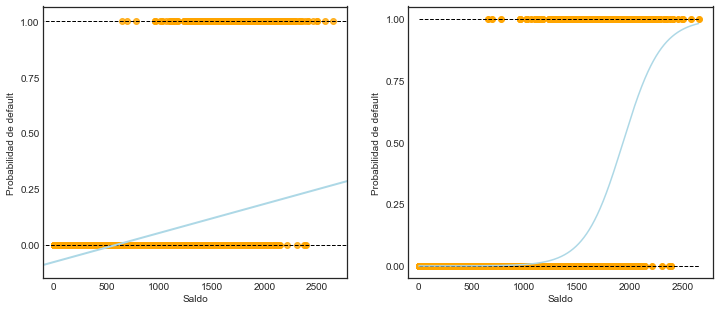

In [4]:
import sklearn.linear_model as skl_lm
X_train = df.balance.values.reshape(-1,1) 
y = df.default2

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y)
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(df.balance, df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'}, line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probabilidad de default')
    ax.set_xlabel('Saldo')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

Para evitar este problema, debemos modelar p(X) usando una función que proporciona salidas entre 0 y 1 para todos los valores de X. Muchas funciones cumplen esta descripción. En la regresión logística, utilizamos la función logística

$$ p(X) = \frac{ e^{\beta_0 + \beta_1X} }{ 1 + e^{\beta_0 + \beta_1X} }$$

Para ajustar el modelo, se utiliza un método llamado _**máxima verosimilitud**_, el cual se discutirá en la siguiente sección. El panel derecho de la figura ilustra el ajuste por este método del modelo de regresión logística a los datos de Default. Observe que para los saldos bajos ahora se predice la probabilidad de incumplimiento cerca de, pero nunca por debajo, cero. Del mismo modo, para los saldos altos se predice una probabilidad de Default cerca, pero nunca superior, a uno. La función logística producirá siempre una curva en forma de S, y así, independientemente del valor de X, obtendremos una predicción razonable. También vemos que el modelo logístico tiene más capacidad de capturar el rango de probabilidades que el modelo de regresión lineal presentado en el gráfico de la izquierda. La probabilidad media ajustada en ambos casos es 0.0333 (promediada sobre los datos de entrenamiento), que es la misma que la proporción total de morosos en el conjunto de datos.

Después de un poco de manipulación de la ecuación, encontramos que:

$$ \frac{p(X)}{1 - p(X)} = e^{\beta_0 + \beta_1X}$$

La cantidad p(X)/[1-p(X)] es llamada cociente de probabilidades (_odds ratio_) o _riesgo relativo_, y puede tomar cualquier valor de entre 0 y  . Los valores del cociente de probabilidades cercanas a 0 y   indican probabilidades de incumplimiento muy bajas y muy altas, respectivamente. Por ejemplo, en promedio, 1 de cada 5 personas estará en default para un riesgo relativo de 1/4, ya que si $p(X) = 0.2$ entonces el cociente de probabilidades es de 0.2/(1-0.2) = 1/4. Del mismo modo, en promedio, nueve de cada diez personas estarán en default con un riesgo relativo de 9, ya que $p(X) = 0.9$ implica un cociente de probabilidades de 0.9/(1-0.9) = 9.

Tomando el logaritmo de ambos lados, llegamos a:

$$ log \bigg(\frac{p(X)}{1 - p(X)} \bigg) = \beta_0 + \beta_1X $$

El lado izquierdo se llama _**logit**_. Se observa que el modelo de regresión logística anterior tiene
un logit que es lineal en $X$.

La cantidad que $p(X)$ cambia debido a un cambio de una unidad en X dependerá del valor actual de $X$. Pero independientemente del valor de $X$, si β1 es positivo, entonces el aumento de X se asociará con el aumento de p(X), y si β1 es negativo, entonces el aumento de $X$ se asociará con la disminución de p(X). El hecho de que no exista una relación lineal entre $p(X)$ y $X$, y el hecho de que la tasa de cambio en $p(X)$ por unidad de cambio en $X$ depende del valor actual de $X$, también puede ser visto por inspección del panel derecho de la figura.

El cambio en $p(X)$ cuando $X$ cambia en una unidad es:

$$ \frac{dp(X)}{dX} = \frac{ e^{\beta_0 + \beta_1X}}{ (1 + e^{\beta_0 + \beta_1X})^2 } \beta_1$$

El cual depende de $X$.

### Estimación de los Coeficientes de Regresión

Los coeficientes $\beta_0$ y $\beta_1$ son desconocidos y deben estimarse basándose en los datos de entrenamiento disponibles. En el modelo de regresión lineal, se utilizó el método de mínimos cuadrados para estimar los coeficientes desconocidos de la regresión. Aunque podríamos utilizar mínimos cuadrados (no lineales) para ajustar el modelo, se prefiere el método más general de _**máxima verosimilitud**_, ya que tiene mejores propiedades estadísticas. 

La intuición básica detrás de la utilización de la máxima verosimilitud para ajustar el modelo de regresión logística es la siguiente: buscamos estimaciones para $\beta_0$ y $\beta_1$ de modo que la probabilidad de default predicha $\hat p (x_i)$ para cada individuo, corresponda lo más cerca posible al estado de default del individuo observado. En otras palabras, tratamos de encontrar $\beta_0$ y $\beta_1$ tales que al colocar estas estimaciones en el modelo para $p(X)$, se produce un número cercano a uno para todos los individuos que cayeron en default y un número cercano a cero para todos los individuos que no lo hicieron. Esta intuición puede formalizarse usando una ecuación matemática llamada **_función de verosimilitud_**

$$ e(\beta_0, \beta_1) = \prod_{i:y_i=1} p(x_i) \prod_{i':y_i'=0} (1 - p(x_i)) $$

Las estimaciones  $\hat \beta_0 y \hat \beta_1$ se eligen de forma que maximicen esta función de verosimilitud.

**La máxima verosimilitud es un enfoque muy general que se utiliza para ajustar muchos de los modelos _no lineales_**. _En el ajuste de regresión lineal, el enfoque de mínimos cuadrados es de hecho un caso especial de máxima verosimilitud_. Los detalles matemáticos de máxima verosimilitud están fuera del alcance de estas notas. Sin embargo, en general, la regresión logística y otros modelos pueden ajustarse fácilmente por máxima verosimilitud utilizando código como verremos a continuación, por lo que no necesitamos preocuparnos por los detalles del procedimiento de ajuste de máxima verosimilitud.

La siguiente tabla muestra las estimaciones de los coeficientes y la información relacionada que resultan del ajuste de un modelo de regresión logística en los datos de Default con el fin de predecir la probabilidad de default = Sí utilizando el saldo. Vemos que  $\hat \beta_1 = 0.0055$; esto indica que un aumento en el saldo está asociado con un aumento en la probabilidad de incumplimiento. Para ser exactos, un aumento de una unidad en el saldo se asocia con un aumento en el logit de default de 0.0055 unidades.

In [5]:
# Con StastModel 
import statsmodels.api as sm
import statsmodels.formula.api as smf
X_train = sm.add_constant(df.balance)
est = smf.Logit(y.ravel(), X_train).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


/anaconda/envs/gisenv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.6513,0.361,-29.491,0.000,-11.359,-9.943
balance,0.0055,0.000,24.952,0.000,0.005,0.006


In [6]:
# Utilizando el solver=newton-cg, los coeficientes son iguales o mas cercanos a los que se presentan en el libro. 
# Es necesario explorar mas en detalle que tipo de solver es mas adecuado y en que situación
clf = skl_lm.LogisticRegression(solver='newton-cg', max_iter=1000)
X_train = df.balance.values.reshape(-1,1)
y = df.default2
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
classes:  [0 1]
coefficients:  [[ 0.00549892]]
intercept : [-10.65133006]


/anaconda/envs/gisenv/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda/envs/gisenv/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Muchos aspectos de la salida de regresión logística mostrados en la tabla son similares a la salida de la regresión lineal. Por ejemplo, podemos medir la exactitud de las estimaciones de los coeficientes calculando sus errores estándar. La estadística z desempeña el mismo papel que la estadística t en la salida de regresión lineal. Puesto que el p-valor asociado con el saldo en la tabla es pequeño, podemos rechazar $H_0$. En otras palabras, concluimos que existe de hecho una asociación entre el saldo y la probabilidad de incumplimiento. El intercepto estimado en la tabla no suele ser de interés; su propósito principal es hacer que el promedio de las probabilidades ajustadas sea igual a la proporción de unos en los datos.

### Predicciones
Una vez que los coeficientes se han estimado, es fácil calcular la probabilidad de incumplimiento para cualquier saldo de la tarjeta de crédito. Por ejemplo, utilizando las estimaciones de coeficientes que se dan en la tabla anterior, se predice que la probabilidad de incumplimiento para un individuo con un saldo de $1,000:

$$ \hat p(X) = \frac{ e^{\hat\beta_0 + \hat\beta_1X} }{ 1 + e^{\hat\beta_0 + \hat\beta_1X} } = \frac{ e^{-10.65133006 + 0.00549892 \times 1000} }{ 1 + e^{-10.65133006 + 0.00549892 \times 1000} } = 0.00576$$

que es inferior al 1%. En contraste, la probabilidad predicha de incumplimiento para un individuo con un saldo de $2,000 es mucho mayor, e igual a 0.586 o 58.6%.

In [7]:
X_test = pd.DataFrame({'balance': [1000, 2000]})
#X_test.head()
#clf.predict(X_test.values.reshape(-1,1)) # [[1000]]
prob = clf.predict_proba([[1000]])
prob2 = clf.predict_proba([[2000]])
print("La probabilidad de incumplimiento para un individuo con un saldo de $1,000: %.5f" % prob[0][1])
print("La probabilidad de incumplimiento para un individuo con un saldo de $2,000: %.3f" % prob2[0][1])

La probabilidad de incumplimiento para un individuo con un saldo de $1,000: 0.00575
La probabilidad de incumplimiento para un individuo con un saldo de $2,000: 0.586


Se pueden utilizar predictores cualitativos con el modelo de regresión logística utilizando el enfoque de variable ficticia de la sección anterior. Como ejemplo, el conjunto de datos de Default contiene una variable cualitativa llamada student.

Para ajustar el modelo simplemente creamos una variable ficticia que toma un valor de 1 para los estudiantes y de 0 para los no estudiantes. El modelo de regresión logística que resulta para la predicción de la probabilidad de incumplimiento usando la condición de estudiante se puede ver en la siguiente tabla:

In [8]:
X_train = sm.add_constant(df.student2)
y = df.default2

est = smf.Logit(y, X_train).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,coef,std err,z,P>|z|,[0.025,0.975]
const,-3.5041,0.071,-49.554,0.000,-3.643,-3.366
student2,0.4049,0.115,3.520,0.000,0.179,0.630


El coeficiente asociado a la variable dummy es positivo y el p-valor asociado es estadísticamente significativo. Esto indica que los estudiantes tienden a tener probabilidades de incumplimiento más altas que los no estudiantes:

$$ \hat {Pr} (default=Yes \space | \space student=Yes) = \frac{ e^{-3.5041 + 0.4049 	 \times 1} }{ 1 + e^{-3.5041 + 0.4049 	 \times 1} } = 0.0431$$

$$ \hat {Pr} (default=Yes \space | \space student=No) = \frac{ e^{-3.5041 + 0.4049 	 \times 0} }{ 1 + e^{-3.5041 + 0.4049 	 \times 0} } = 0.0292 $$


## Regresión Logística Múltiple 
Considere el problema de predecir una respuesta binaria usando múltiples predictores.

$$ p(X) = \frac{ e^{\beta_0 + \beta_1X_1 + ... + \beta_pX_p} }{ 1 + e^{\beta_0 + \beta_1X_1 + ... + \beta_pX_p} }$$


La siguiente tabla muestra las estimaciones de los coeficientes para un modelo de regresión logística que utiliza el **saldo**, los **ingresos** (en miles de dólares) y el **estado del estudiante** para predecir la probabilidad de default. Aparece un resultado sorprendente. Los p-valores asociados al saldo y a la variable ficticia para el estatus estudiantil son muy pequeños, lo que indica que cada una de estas variables está asociada con la probabilidad de default. Sin embargo, el coeficiente de la variable ficticia es negativo, lo que indica que los estudiantes tienen menos probabilidad de caer en default que los que no estudian. Esto es contrario al signo del coeficiente de la variable dummy que era positivo en la tabla anterior.

**¿Cómo es posible que el estatus de estudiante esté asociado con un aumento en la probabilidad de default en la tabla anterior y una disminución en la probabilidad de default en la siguiente tabla?**

In [9]:
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
est = smf.Logit(y, X_train).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.8690,0.492,-22.079,0.000,-11.834,-9.904
balance,0.0057,0.000,24.737,0.000,0.005,0.006
income,3.033e-06,8.2e-06,0.370,0.712,-1.3e-05,1.91e-05
student2,-0.6468,0.236,-2.738,0.006,-1.110,-0.184


El panel izquierdo de la siguiente figura proporciona una ilustración gráfica de esta aparente paradoja. Las líneas sólidas anaranjadas y azules muestran, respectivamente, las tasas de incumplimiento promedio para estudiantes y no estudiantes, en función del saldo de la tarjeta de crédito. El coeficiente negativo para el estudiante en la regresión logística múltiple indica que para un valor fijo de saldo e ingreso, un estudiante tiene menos probabilidades de incumplimiento que un no estudiante. De hecho, observamos en el panel izquierdo de la figura que la tasa de incumplimiento de los estudiantes es igual o inferior a la tasa de incumplimiento de no estudiantes para cada valor del saldo.

#### Confusión

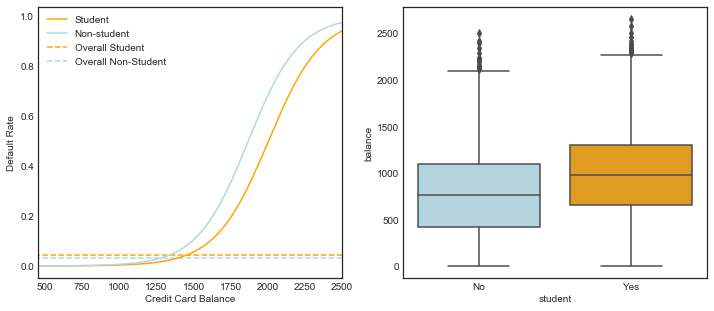

In [10]:
# vectores de saldo y default para estudiantes
X_train = df[df.student == 'Yes'].balance.values.reshape(df[df.student == 'Yes'].balance.size,1) 
y = df[df.student == 'Yes'].default2

# vectores de saldo y default para no estudiantes
X_train2 = df[df.student == 'No'].balance.values.reshape(df[df.student == 'No'].balance.size,1) 
y2 = df[df.student == 'No'].default2

# Vector con los valores de saldo para gráficar
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf2 = skl_lm.LogisticRegression(solver='newton-cg')

clf.fit(X_train,y)
clf2.fit(X_train2,y2)

prob = clf.predict_proba(X_test)
prob2 = clf2.predict_proba(X_test)

# creamos la gráfica
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Gráfico izquierdo
ax1.plot(X_test, pd.DataFrame(prob)[1], color='orange', label='Student')
ax1.plot(X_test, pd.DataFrame(prob2)[1], color='lightblue', label='Non-student')
ax1.hlines(127/2817, colors='orange', label='Overall Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(206/6850, colors='lightblue', label='Overall Non-Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

# Gráfico derecho
sns.boxplot('student', 'balance', data=df, orient='v', ax=ax2,  palette=c_palette);

Sin embargo, las líneas horizontales punteadas cerca de la base del gráfico, que muestran las tasas de incumplimiento de estudiantes y no estudiantes promediados sobre todos los valores de saldo e ingreso, sugieren el efecto opuesto: la tasa general de default de los estudiantes es mayor que la tasa de los no estudiantes. En consecuencia, existe un coeficiente positivo para el estudiante en la regresión logística con la sola variable predictora dummy que se muestra en la tabla anterior.

El panel derecho de la figura proporciona una explicación para esta discrepancia. Las variables estudiante y saldo están correlacionadas. Los estudiantes tienden a tener mayores niveles de deuda, lo que a su vez está asociado con una mayor probabilidad de default. En otras palabras, es más probable que los estudiantes tengan grandes saldos de tarjetas de crédito, que, como sabemos por el panel izquierdo de la figura, tienden a estar asociados con altas tasas de morosidad.

Por lo tanto, aunque un estudiante individual con un saldo de tarjeta de crédito dado tiende a tener una menor probabilidad de incumplimiento que un no-estudiante con el mismo saldo de tarjeta de crédito, el hecho de que los estudiantes en general tienden a tener mayores saldos de tarjetas de crédito significa que en general, los estudiantes tienden a incumplir a una tasa más alta que los no-estudiantes. Esta es una distinción importante para una compañía de tarjetas de crédito que está tratando de determinar a quién deben ofrecer crédito. Un estudiante es más riesgoso que un no-estudiante si no hay información disponible sobre el saldo de la tarjeta de crédito del estudiante. Sin embargo, ese estudiante es menos riesgoso que un no estudiante con el mismo saldo de tarjeta de crédito.

Este sencillo ejemplo ilustra los peligros y sutilezas asociados con la realización de regresiones que implican sólo un único predictor cuando otros predictores también pueden ser relevantes. Al igual que en el ajuste de regresión lineal, los resultados obtenidos utilizando un predictor pueden ser bastante diferentes de los obtenidos utilizando múltiples predictores, especialmente cuando existe correlación entre los predictores. En general, el fenómeno visto en la figura se conoce como **confusión**.

In [11]:
# Matrix de confusión del ejemplo anterior
df.groupby(['student','default']).size().unstack('default')

default    No  Yes
student           
No       6850  206
Yes      2817  127

Al sustituir las estimaciones de los coeficientes de regresión de la tabla anterior en la ecuación de regresión logistica multiple, podemos hacer predicciones. Por ejemplo, un estudiante con un saldo de tarjeta de crédito de  1,500 y un ingreso de 40,000 tiene una probabilidad estimada de default de:

$$ \hat p(X) = \frac{ e^{-10.8690 + 0.0057X_1 + 0.003X_2 - 0.6468X_3} }{ 1 + e^{-10.8690 + 0.0057X_1 + 0.003X_2 - 0.6468X_3} } = \frac{ e^{-10.8690 + 0.0057 \times 1500 + 0.003 \times 40 - 0.6468 \times 1} }{ 1 + e^{-10.8690 + 0.0057 \times 1500 + 0.003 \times 40 - 0.6468 \times 1} } = 0.058 $$


Un no estudiante con el mismo saldo e ingresos tiene una probabilidad estimada de incumplimiento de:

$$ \hat p(X) = \frac{ e^{-10.8690 + 0.0057X_1 + 0.003X_2 - 0.6468X_3} }{ 1 + e^{-10.8690 + 0.0057X_1 + 0.003X_2 - 0.6468X_3} } = \frac{ e^{-10.8690 + 0.0057 \times 1500 + 0.003 \times 40 - 0.6468 \times 0} }{ 1 + e^{-10.8690 + 0.0057 \times 1500 + 0.003 \times 40 - 0.6468 \times 0} } = 0.105 $$

Note que aquí multiplicamos la estimación del coeficiente de ingreso de la tabla por 40, en vez de por 40,000, porque en esa tabla el modelo estaba en forma con ingresos medidos en unidades de 1,000).


In [12]:
prob3 = clf.predict_proba([[1500], [40]])
prob4 = clf2.predict_proba([[1500], [40]])
print("La probabilidad de incumplimiento para un estudiante con un saldo de $1,500 e ingreso $40,000: %.3f" % prob3[0][1])
print("La probabilidad de incumplimiento para un no-estudiante con un saldo de $1,500 e ingreso $40,000: %.3f" % prob4[0][1])

La probabilidad de incumplimiento para un estudiante con un saldo de $1,500 e ingreso $40,000: 0.056
La probabilidad de incumplimiento para un no-estudiante con un saldo de $1,500 e ingreso $40,000: 0.105


## Análisis Discriminante Lineal - LDA
La regresión logística implica modelar directamente Pr(Y = k | X = x) utilizando la función logística, dada por ecuación anterior para el caso de una respuesta con dos categorías. En la jerga estadística, modelamos la distribución condicional de la respuesta Y, dado los predictores X. Consideremos un enfoque alternativo y menos directo para estimar estas probabilidades. En este enfoque alternativo, modelamos la distribución de los predictores X por separado en cada una de las categorías de la respuesta (es decir, dado Y), y luego usamos el teorema de Bayes para obtener las estimaciones de Pr(Y = k |X = x). Cuando se supone que estas distribuciones son normales, el modelo que resulta es muy similar en su forma a la regresión logística.

**¿Por qué necesitamos otro método, cuando ya tenemos la regresión logística?** Hay varias razones:

- Cuando las clases están bien separadas, las estimaciones de parámetros para el modelo de regresión logística son sorprendentemente inestables. El análisis discriminante lineal no sufre este problema.

- Si n es pequeño y la distribución de los predictores X es aproximadamente normal en cada una de las clases, el modelo discriminante lineal es de nuevo más estable que el modelo de regresión logística.

- Como se mencionó en la Sección anterior, el análisis discriminante lineal es más empleado cuando tenemos más de dos categorías en la respuesta.

### Uso del teorema de Bayes para la clasificación
Supongamos que deseamos clasificar una observación en una de las K clases, donde K ≥ 2. En otras palabras, la variable de respuesta cualitativa $Y$ puede asumir K posibles valores distintos y no ordenados. Sea πk la probabilidad total o _a priori_ de que una observación elegida aleatoriamente provenga de la k-ésima categoría; esta es la probabilidad de que una observación dada esté asociada con la k-ésima categoría de la variable de respuesta $Y$. Sea fk(X) ≡ Pr (X = x | Y = k) la _función de densidad_ de X para una observación que proviene de la k-ésima clase.

En otras palabras, fk(x) es relativamente grande si existe una alta probabilidad de que una observación en la clase k tenga X ≈ x, y fk(x) es pequeña si es muy improbable que una observación en la clase k tenga X ≈ x. Entonces el **_teorema de Bayes_** afirma que:

$$ P_r (Y = k \space | \space X = x) = \frac{\pi_k f_k(x)}{ \sum_{l=1}^K \pi_l f_l(x)}$$

De acuerdo con nuestra notación, usaremos la notación $p_k(X)$ = Pr (Y = k | X=x). Esto sugiere que en lugar de calcular directamente $p_k(X)$ como en la Sección anterior, podemos simplemente colocar las estimaciones de $\pi_k$ y $f_k(X)$. En general, estimar πk es fácil si tenemos una muestra aleatoria de Y de la población: simplemente calculamos la fracción de las observaciones de entrenamiento que pertenecen a la k-ésima categoría. Sin embargo, estimar $f_k(X)$ tiende a ser más difícil, a menos que asumamos algunas formas simples para estas densidades. Nos referimos a $p_k(X)$ como la probabilidad posterior de que una observación X = x pertenezca a la categoría k. Es decir, es la probabilidad de que la observación pertenezca a la categoría k, dado el valor del predictor para esa observación.

Se sabe que el clasificador de Bayes, que clasifica una observación en la categoría para la cual $p_k(X)$ es la más grande, tiene la tasa de error más baja posible entre todos los clasificadores. (Por supuesto, esto sólo es cierto si los términos en la ecuación anterior están correctamente especificados). Por tanto, si podemos encontrar una forma de estimar $f_k(X)$, entonces podemos desarrollar un clasificador que se aproxima al clasificador de Bayes. Este enfoque es el tema de las siguientes secciones.

En una situación real, no podemos calcular el clasificador de Bayes.

![LDA](./assets/LDA.png)

### Análisis Discriminante Lineal para p = 1
Supongamos que asumimos que $f_k(X)$ es normal o Gaussiana. En el caso unidimensional, la densidad normal toma la forma:

$$ f_k(X) = \frac{1}{\sqrt{2\pi \sigma_k}} exp \bigg ( - \frac{1}{ 2\sigma_k^2} (x - u_k)^2  \bigg )$$

Donde $u_k$ y $\sigma_k^2$ son los parámetros de media y varianza para la k-ésima categoría. kk
Por ahora, supongamos que  $\sigma_1^2 = \sigma_2^2 = ... = \sigma_k^2$ , es decir, el parámetro de varianza es el mismo en todas las K clases.

(Observe que en la ecuación, πk denota la probabilidad a priori de que una observación pertenezca a la categoría k, que no debe confundirse con π ≈ 3.14159, la constante matemática.)


### Análisis Discriminante Lineal para p>1

Ahora extenderemos el clasificador LDA al caso de múltiples predictores. Para ello, asumiremos que X = (X 1, X 2, ..., X p) se extrae de una distribución Gaussiana multivariable (o normal multivariable), con un vector de medias específico para cada clase y una matriz de covarianza común. La distribución gaussiana multivariable supone que cada predictor individual sigue una distribución normal unidimensional, con alguna correlación entre cada par de predictores.

Dos ejemplos de distribuciones Gaussianas multivariantes con p=2 se muestran en los paneles de la siguiente figura. La altura de la superficie en cualquier punto particular representa la probabilidad de que tanto X1 como X2 caigan en una pequeña región alrededor de ese punto. En cualquier panel, si la superficie se corta a lo largo del eje X1 o a lo largo del eje X2, la sección resultante tendrá la forma de una distribución normal unidimensional. El panel izquierdo de la Figura ilustra un ejemplo en el que Var(X1) = Var(X2) y Cor(X1, X2)=0; esta superficie tiene una forma de campana característica. Sin embargo, la forma de la campana se distorsionará si los predictores están correlacionados o tienen varianzas desiguales, como se ilustra en el panel derecho de la Figura.

![Gauss](./assets/Gauss.png)

En esta situación, la base de la campana tendrá una forma elíptica, en vez de circular. Para indicar que una variable aleatoria p-dimensional X tiene una distribución Gaussiana
multivariable, escribimos X ~ N (μ, Σ). Aquí E (X) = μ es la media de X (un vector con p componentes), y Cov (X) = Σ es la matriz de covarianza p×p de X. 


Se muestran tres clases Gaussianas con vectores de medias específicos en cada clase y una matriz de covarianza común. Las tres elipses representan regiones que contienen el 95% de la probabilidad para cada una de las tres clases. Las líneas discontinuas son las cotas de decisión de Bayes. Observe que hay tres líneas que representan los límites de decisión de Bayes porque hay tres pares de clases entre las tres clases. Es decir, un límite de decisión de Bayes separa la clase 1 de la clase 2, otro separa la clase 1 de la clase 3 y otro separa la clase 2 de la clase 3. Estas tres cotas de decisión de Bayes dividen el espacio predictor en tres regiones. El clasificador de Bayes clasificará una observación de acuerdo con la región en la que se encuentra. 

![Bayes](./assets/Bayes.png)


En el panel derecho de la figura, se muestran 20 observaciones extraídas de cada una de las tres categorías, y las cotas de decisión del LDA resultantes se muestran como líneas negras sólidas. En general, las cotas de la decisión del LDA están muy cerca de los límites de decisión de Bayes, que se muestran nuevamente como líneas discontinuas.

Las tasas de error de prueba para los clasificadores Bayes y LDA son 0.0746 y 0.0770, respectivamente. Esto indica que LDA tiene un buen comportamiento en estos datos.

Se puede emplear el LDA en los datos de Default con el fin de predecir si un individuo incumplirá o no en función del saldo de la tarjeta de crédito y del estado de estudiante. El modelo LDA ajustado a las 10.000 muestras de entrenamiento da como resultado una tasa de error de entrenamiento de 2.75%. Esto suena como una baja tasa de error, pero hay que tener en cuenta dos advertencias.

- En primer lugar, las tasas de error de entrenamiento por lo general serán menores que las tasas de error de prueba, que son la cantidad real de interés. En otras palabras, podríamos esperar que este clasificador tenga un desempeño peor si lo usamos para predecir si un nuevo conjunto de individuos caerá en default. La razón es que ajustamos específicamente los parámetros de nuestro modelo para que se comporte bien con los datos de entrenamiento. Cuanto más alto sea el cociente entre el número de parámetros p y el número de observaciones n, más esperamos que este sobre- ajuste (_overfitting_) juegue su papel. Para estos datos no esperamos que esto sea un problema, ya que p=2 y n=10,000.

- En segundo lugar, ya que sólo un 3.33% de los individuos en la muestra de entrenamiento no cumplieron con la obligación (cayeron en default), un clasificador simple pero poco útil que siempre predice que cada individuo no incurrirá en default, independientemente del saldo de su tarjeta de crédito y del estado de estudiante, producirá una tasa de error de 3.33%. En otras palabras, el clasificador nulo trivial alcanzará una tasa de error que es sólo un poco mayor que la tasa de error de entrenamiento del LDA.

En la práctica, un clasificador binario como éste puede producir dos tipos de errores: puede asignar incorrectamente a un individuo que incumple a la categoría de _no incumplimiento_ o asignar incorrectamente a un individuo que no incumple a la categoría de _incumplimiento_. A menudo es de interés para determinar cuáles de estos dos tipos de errores se están cometiendo. Una _matriz de confusión_, mostrada para los datos de Default en la siguiente tabla, es una forma conveniente de mostrar esta información. La tabla revela que el LDA pronosticó que un total de 101 personas no pagarían.

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score

X = df[['balance', 'income', 'student2']].as_matrix()
y = df.default2.as_matrix()

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y).predict(X)

df_ = pd.DataFrame({'True default status': y, 'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status         No  Yes
Predicted default status           
No                        9645  254
Yes                         22   79

In [14]:
print(classification_report(y, y_pred, target_names=['No', 'Yes']))

             precision    recall  f1-score   support

         No       0.97      1.00      0.99      9667
        Yes       0.78      0.24      0.36       333

avg / total       0.97      0.97      0.97     10000



De estas personas, 79 en realidad incumplieron y 22 no lo hicieron. Por lo tanto, sólo 22 de los 9,667 individuos que no incumplieron fueron asignados incorrectamente.

Esta parece una tasa de error bastante baja! Sin embargo, de los 333 individuos que incumplieron, 252 (o 75.7%) fueron mal clasificados por el LDA. Así, mientras que la tasa de error global es baja, la tasa de error entre los individuos que incumplieron es muy alta. Desde la perspectiva de una compañía de tarjetas de crédito que está tratando de identificar a las personas de alto riesgo, una tasa de error de 252/333 = 75.7% entre las personas que incumplieron puede ser inaceptable.

El desempeño específico de la asignación a la categoría también es importante en medicina y biología, donde los términos _sensibilidad_ y _especificidad_ caracterizan el desempeño de un clasificador o una prueba de detección. En este caso, la sensibilidad es el porcentaje de defraudadores verdaderos identificados, un 24.3%, bajo en este caso. La especificidad es el porcentaje de no incumplidores que se identifican correctamente, aquí (1 -23/9, 667) x 100 = 99.8%.

¿Por qué LDA hace un trabajo tan pobre de clasificar a los clientes que caen en default? En otras palabras, ¿por qué tiene una sensibilidad tan baja? Como hemos visto, LDA está intentando aproximar el clasificador de Bayes, que tiene la tasa de error total más baja de todos los clasificadores (si el modelo gaussiano es correcto).

Es decir, el clasificador de Bayes producirá el número total más pequeño posible de observaciones mal clasificadas, independientemente de la clase de error del que proceden. Es decir, algunas clasificaciones erróneas resultarán de asignar incorrectamente a un cliente que no entra en default a la categoría de los que sí entran en default, y otros resultarán de asignar incorrectamente a un cliente que incumple a la clase de los que no incumplen. Una compañía de tarjetas de crédito podría desear evitar clasificar incorrectamente a un individuo que incumplirá, mientras que clasificar incorrectamente a un individuo que no defraudará, aunque debería ser evitado, es menos problemático. Ahora veremos que es posible modificar LDA para desarrollar un clasificador que satisfaga mejor las necesidades de la compañía de tarjetas de crédito.

El clasificador de Bayes funciona asignando una observación a la categoría para la cual la probabilidad posterior pk(X) es mayor. En el caso de dos categorías, esto equivale a asignar una observación a la clase default si

$$ Pr (default = Sí | X = x)> 0.5 $$

Por lo tanto, el clasificador de Bayes, y por extensión el LDA, utiliza un umbral del 50% para la probabilidad posterior de default para asignar una observación a la clase de incumplimiento. Sin embargo, si nos preocupa predecir incorrectamente el estado de default para las personas que incumplen, podemos considerar la reducción de este umbral. Por ejemplo, podríamos clasificar a cualquier cliente con una probabilidad posterior de incumplimiento por encima del 20% a la clase de incumplimiento. En otras palabras, en lugar de asignar una observación a la clase de incumplimiento si la anterior Pr se cumple, podríamos asignar una observación a esta clase si


$$ Pr (default = Sí | X = x)> 0.2 $$

Las tasas de error que resultan de tomar este enfoque se muestran en la siguiente tabla. Ahora, LDA predice que 425 personas serán las incumplidas. De los 333 individuos que incumplen, LDA los predice correctamente todos, excepto a 140, o el 42.04%. Esta es una gran mejora con respecto a la tasa de error del 75.7% que resultó del uso del umbral del 50%. Sin embargo, esta mejora tiene un costo: ahora 232 personas que no incumplen están mal clasificados. Como resultado, la tasa de error global ha aumentado ligeramente hasta el 3.73%. Pero una compañía de tarjetas de crédito puede considerar este ligero aumento en la tasa de error total como un pequeño precio a pagar por una identificación más precisa de las personas que de hecho entran en default.

In [15]:
decision_prob = 0.2
y_prob = lda.fit(X, y).predict_proba(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status         No  Yes
Predicted default status           
No                        9435  140
Yes                        232  193

La siguiente figura ilustra el trade-off que resulta de la modificación del valor umbral para la probabilidad posterior de incumplimiento. Se muestran las tasas de error en función del valor de umbral. Utilizando un umbral de 0.5, se minimiza la tasa de error global, mostrada como una línea continua negra. Esto es de esperar, ya que el clasificador Bayes utiliza un umbral de 0.5 y se sabe que tiene la menor tasa de error global. Pero cuando se utiliza un umbral de 0.5, la tasa de error entre los individuos que incumplen es bastante alta (línea azul discontinua). A medida que se reduce el umbral, la tasa de error entre los individuos que incumplen disminuye de manera constante, pero la tasa de error entre los individuos que no incumplen aumenta. ¿Cómo podemos decidir qué valor de umbral es mejor? Tal decisión debe basarse en el _conocimiento de las implicaciones en el área de aplicación_, tal como información detallada sobre los costos asociados al incumplimiento.

![Trade-off](./assets/tradeoff.png)



## La curva ROC
La curva ROC es un gráfico popular para mostrar simultáneamente los dos tipos de errores para todos los posibles umbrales. La siguiente figura muestra la curva ROC del clasificador LDA para los datos de entrenamiento. El comportamiento global de un clasificador, resumido sobre todos los umbrales posibles, viene dado por el _área bajo la curva_ ROC (AUC). Una curva ROC ideal pasará cerca de la esquina superior izquierda, por lo que cuanto mayor sea el AUC, mejor será el clasificador. Para estos datos el AUC es 0.95, que es cercano al máximo de 1.00 por lo que el clasificador sería considerado muy bueno. Un clasificador que no funciona mejor que el azar tiene un AUC de 0.5 (cuando se evalúa en un conjunto de datos de prueba independiente, no con los datos de entrenamiento del modelo).

Las curvas ROC son útiles para comparar diferentes clasificadores, ya que tienen en cuenta todos los umbrales posibles. La curva ROC para el modelo de regresión logística ajustado a estos datos es virtualmente indistinguible de la obtenida para el modelo LDA.

![ROC Curve](./assets/ROC.png)

In [16]:
# Ejemplo de Analisis Discriminante lineal con los datos del laboratorio del libro ISLR
df = pd.read_csv('Data/Smarket.csv', usecols=range(1,10), index_col=0, parse_dates=True)
X_train = df[:'2004'][['Lag1','Lag2']]
y_train = df[:'2004']['Direction']

X_test = df['2005':][['Lag1','Lag2']]
y_test = df['2005':]['Direction']

lda = LinearDiscriminantAnalysis()
pred = lda.fit(X_train, y_train).predict(X_test)
lda.priors_

array([ 0.49198397,  0.50801603])

In [17]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [18]:
# Parece que no corresponde a los presentados en el libro con R. Es necesario revisar los datos
lda.coef_

array([[-0.05544078, -0.0443452 ]])

In [19]:
confusion_matrix(y_test, pred).T

array([[ 35,  35],
       [ 76, 106]])

In [20]:
print(classification_report(y_test, pred, digits=3))

             precision    recall  f1-score   support

       Down      0.500     0.315     0.387       111
         Up      0.582     0.752     0.656       141

avg / total      0.546     0.560     0.538       252



In [21]:
pred_p = lda.predict_proba(X_test)
np.unique(pred_p[:,1]>0.5, return_counts=True)

(array([False,  True], dtype=bool), array([ 70, 182]))

In [22]:
np.unique(pred_p[:,1]>0.9, return_counts=True)

(array([False], dtype=bool), array([252]))

## Análisis Discriminante Cuadrático
El LDA supone que las observaciones dentro de cada categoría se toman de una distribución Gaussiana multivariable con un vector de medias específico en cada categoría y una matriz de covarianza que es común a todas las K clases. El _análisis discriminante cuadrático_ (QDA) proporciona un enfoque alternativo. Al igual que LDA, el clasificador QDA resulta de suponer que las observaciones de cada clase se toman de una distribución gaussiana, y de colocar las estimaciones de los parámetros en el teorema de Bayes para realizar la predicción. Sin embargo, lo que diferencia al LDA del QDA es que éste último supone que cada categoría tiene su propia matriz de covarianza. Es decir, asume que una
observación de la k-ésima categoría es de la forma X ~ N (μk, Σk), donde Σk es la matriz de covarianza para la categoría k.

¿Por qué importa si asumimos o no que las K clases comparten una matriz de covarianza común? En otras palabras, ¿por qué se preferiría LDA a QDA, o viceversa? La respuesta radica en el trade-off del sesgo-varianza. Cuando hay p predictores, la estimación de una matriz de covarianza requiere estimar p(p+1)/2 parámetros. QDA estima una matriz de covarianza separada para cada clase, para un total de Kp(p+1)/2 parámetros. Con 50 predictores es un múltiplo de 1,275, lo cual es una gran cantidad de parámetros. Al suponer que las K clases comparten una matriz de covarianza común, el modelo LDA se vuelve lineal en x, lo que significa que hay Kp coeficientes lineales para estimar.

En consecuencia, LDA es un clasificador mucho menos flexible que QDA, y por lo tanto tiene una varianza sustancialmente menor. Esto puede conducir potencialmente a un mejor desempeño en la predicción. Pero hay un trade-off: si el supuesto del LDA de que las K clases comparten una matriz de covarianza común no es correcto, entonces LDA puede sufrir de un sesgo alto.

>En términos generales, el LDA tiende a ser un mejor clasificador que QDA si hay relativamente pocas observaciones de entrenamiento y por lo tanto la reducción de la varianza es crucial. En cambio, se recomienda QDA si el conjunto de entrenamiento es muy grande, de modo que la varianza del clasificador no es una preocupación importante, o si el supuesto de una matriz de covarianza común para las K clases es claramente insostenible.

La siguiente figura ilustra los resultados de LDA y QDA en dos escenarios. En el panel izquierdo, las dos clases Gaussianas tienen una correlación común de 0.7 entre X1 y X2. Como resultado, la cota de decisión de Bayes es lineal y se aproxima con precisión por la cota de decisión del LDA. La cota de decisión QDA es inferior, ya que sufre de mayor varianza sin una disminución correspondiente en el sesgo. Por el contrario, el panel derecho muestra una situación en la que la categoría naranja tiene una correlación de 0.7 entre las variables y la clase azul tiene una correlación de -0.7. Ahora la cota de la decisión de Bayes es cuadrática, y por lo tanto el QDA se aproxima más exactamente a esta cota que el LDA.

![QDA vs LDA](./assets/LDAvsQDA.png)

**Izquierda**: Las cotas de: Bayes (púrpura en guiones), LDA (punteado negro) y QDA (sólido verde) para un problema de dos categorías con Σ1 = Σ2. El sombreado indica la regla de decisión de QDA. Dado que la cota de la decisión de Bayes es lineal, es mejor aproximada por LDA que por QDA. **Derecha**: Los detalles son los mismos del panel izquierdo, excepto que Σ1 es diferente de Σ2. Dado que la cota de decisión de Bayes no es lineal, se aproxima mejor por QDA que por LDA.

In [23]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
pred = qda.fit(X_train, y_train).predict(X_test)
qda.priors_

array([ 0.49198397,  0.50801603])

In [24]:
qda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [25]:
confusion_matrix(y_test, pred).T

array([[ 30,  20],
       [ 81, 121]])

In [26]:
print(classification_report(y_test, pred, digits=3))

             precision    recall  f1-score   support

       Down      0.600     0.270     0.373       111
         Up      0.599     0.858     0.706       141

avg / total      0.599     0.599     0.559       252



## K-Nearest Neighbors

In [27]:
from sklearn import preprocessing
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred).T)
print(classification_report(y_test, pred, digits=3))

[[43 58]
 [68 83]]
             precision    recall  f1-score   support

       Down      0.426     0.387     0.406       111
         Up      0.550     0.589     0.568       141

avg / total      0.495     0.500     0.497       252



In [28]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred).T)
print(classification_report(y_test, pred, digits=3))

[[48 55]
 [63 86]]
             precision    recall  f1-score   support

       Down      0.466     0.432     0.449       111
         Up      0.577     0.610     0.593       141

avg / total      0.528     0.532     0.529       252



### Un Ejemplo con los datos de seguros Caravan

In [29]:
# In R, I exported the dataset from package 'ISLR' to a csv file
df = pd.read_csv('data/Caravan.csv')
y = df.Purchase
X = df.drop('Purchase', axis=1).astype('float64')
X_scaled = preprocessing.scale(X)

X_train = X_scaled[1000:,:]
y_train = y[1000:]
X_test = X_scaled[:1000,:]
y_test = y[:1000]

def KNN(n_neighbors=1, weights='uniform'):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    return(pred, score, clf.classes_)

def plot_confusion_matrix(cm, classes, n_neighbors, title='Confusion matrix (Normalized)',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix: KNN-{}'.format(n_neighbors))
    plt.colorbar()
    plt.xticks(np.arange(2), classes)
    plt.yticks(np.arange(2), classes)
    plt.tight_layout()
    plt.xlabel('True label',rotation='horizontal', ha='right')
    plt.ylabel('Predicted label')
    plt.show()

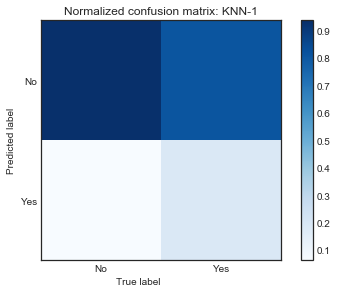

True        No  Yes
Predicted          
No         882   48
Yes         59   11
     Precision
No    0.948387
Yes   0.157143


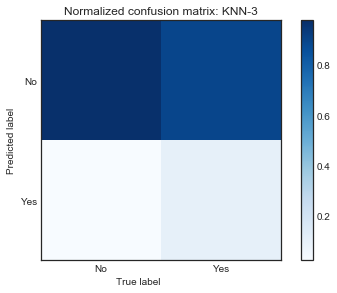

True        No  Yes
Predicted          
No         921   53
Yes         20    6
     Precision
No    0.945585
Yes   0.230769


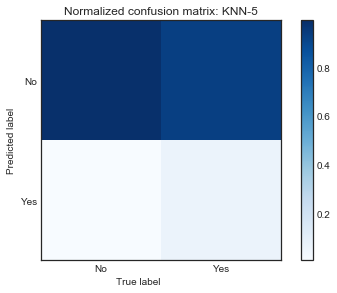

True        No  Yes
Predicted          
No         934   55
Yes          7    4
     Precision
No    0.944388
Yes   0.363636


In [30]:
for i in [1,3,5]:
    pred, score, classes = KNN(i)
    cm = confusion_matrix(y_test, pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized.T, classes, n_neighbors=i)
    cm_df = pd.DataFrame(cm.T, index=classes, columns=classes)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print(cm_df)    
    print(pd.DataFrame(precision_score(y_test, pred, average=None),
                       index=classes, columns=['Precision']))        

#### Probamos con la Regresión Logística

In [31]:
regr = skl_lm.LogisticRegression()
regr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
pred = regr.predict(X_test)
cm_df = pd.DataFrame(confusion_matrix(y_test, pred).T, index=regr.classes_,
                     columns=regr.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)
print(classification_report(y_test, pred))

True        No  Yes
Predicted          
No         935   59
Yes          6    0
             precision    recall  f1-score   support

         No       0.94      0.99      0.97       941
        Yes       0.00      0.00      0.00        59

avg / total       0.89      0.94      0.91      1000



In [33]:
pred_p = regr.predict_proba(X_test)
cm_df = pd.DataFrame({'True': y_test, 'Pred': pred_p[:,1] > .25})
cm_df.Pred.replace(to_replace={True:'Yes', False:'No'}, inplace=True)
print(cm_df.groupby(['True', 'Pred']).size().unstack('True').T)
print(classification_report(y_test, cm_df.Pred))

Pred   No  Yes
True          
No    919   22
Yes    48   11
             precision    recall  f1-score   support

         No       0.95      0.98      0.96       941
        Yes       0.33      0.19      0.24        59

avg / total       0.91      0.93      0.92      1000



### Ejemplo en R  con los datos de Smarket
``` R
rm(list=ls(all=TRUE))
library (ISLR)
# La librería ISLR contiene el archvo Smarket, el cual contiene los retornos en porcentaje 
# para el indice bursátil S&P500 para 1250 días, desde el inicio de 2001 hasta el final
# de 2005. Para cada peróodo, se registró el retorno para cada uno de los cinco días de 
# negociación anteriores, denominados Lag1 hasta Lag5. También se registraron las variables:
# Volume (el número de acciones negociadas el día anterior, en miles de millones),
# Today (el porcentaje de retorno en la fecha en cuestión) y
# Direction es una variable dummy que indica si hubo un retorno positivo o negativo en esa fecha.

?Smarket
Smarket
fix(Smarket)
dim(Smarket)       # muestra el número de observaciones y el numero de variables 
names(Smarket)
attach(Smarket)    # asigna los nombre de las variables a las columnas 
summary(Smarket)   # produce un resumen descriptivo de cada variable

cor(Smarket[,-9])  # produce la matriz de correlación de las variables cuantitativas en Smarket
plot(Year,Volume)  # Volume tiende a crecer con el tiempo
plot(Volume)       # Volume tiende a crecer con el tiempo

# regresión logística
# ------------------------------------------------------------------------------------------------
# ajuste de una regresión logística de Dirección(estado del mercado) sobre Lag1 hasta Lag5 y Volumen
# investiga la probabilidad de que el retorno sea positivo en términos
# de Lag1 hasta Lag5 y Volume

plot(Direction)
(prop_up=mean(Direction=="Up"))  # proporción de retorno positivos

# la función glm() ajusta el modelo lineal generalizado 
# el cual incluye el modelo logístico
glm.fit=glm(Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume, data=Smarket, family =binomial)
summary(glm.fit)                    

?summary.glm      # muestra el contenido de summary para la función glm()

coef(glm.fit)     # muestra los coeficientes estimados
summary(glm.fit)$coef   # muestra una tabla con los coeficientes estimados, su error estándar,
                        # el valor z y el p-valor

summary(glm.fit)$coef[,4]   # muestra el p-valor para la significancia de cada estimador

# predicción de la probabilidad de que el mercado está arriba (produzca retornos positivos)
# para los datos de entrenamiento empleados. 
(glm.probs=predict(glm.fit ,type ="response"))    # type ="response" predice las probabilidades en un modelo logit 
glm.probs[1:10]       # edita las probabilidades predichas para los 10 primeros datos de entrenamiento.  

contrasts(Direction)  # muestra la asignación de la variable dummy 0-1 construida por R para 
                      # la variable respuesta Direction

# construcción de la matriz de confusión
glm.pred=rep("Down" ,1250)  # produce un vector de 1250 con Down como elementos 
glm.pred[glm.probs>.5]="Up" # transforma a Up todos los elementos para los cuales la probabilidad
                            # predicha de que el mercado incremente es mayor que 0.5 
cbind(glm.pred, Direction)
(tabla=table(glm.pred, Direction))  # produce la matriz de confusión para determinar cuántas observaciones
                                    # fueron clasificadas correcta e incorrectamente


(507+145)                   # predicciones correctas en los datos de entrenamiento
(Tasa_pred_corr=100*(507+145)/1250)  # tasa de predicción correcta: el modelo predice correctamente el 52.2% 
                                     # de las veces en los datos de entrenamiento
mean(glm.pred==Direction)  # calcula la fracción de días  para los cuales la predicción fue correcta
                           # es el predictor trivial en los datos de entrenamiento
(prop_up=mean(Direction=="Up"))  # proporción de retorno positivos: predictor trivial de la probabilidad
                                 # de que el mercado se encuentre arriba.

# parece que la regresión logística estuviera trabajando un poco mejor que
# advinar al azar. Sin embargo, esto no es cierto, debido a que se ha estimado y probado
# el modelo con las mismas 1250 observaciones. En otras palabras 
# 100-52.2=47.8% es la tasa de error de entrenamiento.
# La tasa de error de entrenamiento es frecuentemente demasiado optimista, 
# tiende a subestimar la tasa de error de prueba.

# validación cruzada: Usamos una parte de los datos para estimar el modelo logístico
# y otra parte para medir la tasa de clasificación correcta y las tasas de errores 
# datos de entrenamiento
train=(Year<2005)           # vector con 1250 elementos con TRUE para las observaciones antes de 2005
                            # y FALSE para aquellas de 2005
cbind(Year,train)

# datos de prueba
Smarket.2005=Smarket[!train, ]  # extrae las observaciones que son FALSE en train (es decir, 
                                 # las observaciones del año 2005
dim(Smarket.2005)
Direction.2005= Direction[!train]

# ajuste del modelo logístico usando los datos de entrenamiento: su usa el
# argumento subset
glm.fit=glm(Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume, data=Smarket, 
            family=binomial, subset=train)    

table(Direction.2005)

glm.probs=predict(glm.fit, Smarket.2005, type="response")  # predicción de las probabilidades
                                                           # para el conjunto de prueba, es decir para el 2005
glm.pred=rep("Down",length(Direction.2005))
glm.pred[glm.probs>.5]="Up"
table(glm.pred, Direction.2005)     # matriz de confusión

mean(glm.pred==Direction.2005)      # tasa de clasificación correcta en el conjunto de prueba
mean(glm.pred!=Direction.2005)      # tasa de error total en el conjunto de prueba

# Los resultados son bastante decepcionantes: la tasa de error de prueba es 
# del 52%, ¡lo que es peor que adivinar al azar! Por supuesto, este resultado
# no es tan sorprendente, dado que generalmente no se espera poder usar los
# retornos de los días anteriores para predecir el desempeño futuro del mercado.

# ajuste del modelo logístico eliminando las variables menos importantes en la predicción
# para tratar de obtener un modelo más efectivo.
glm.fit=glm(Direction~Lag1+Lag2, data=Smarket, family =binomial, subset=train)
summary(glm.fit)
glm.probs=predict(glm.fit, Smarket.2005, type="response")
glm.pred=rep("Down", 252)
glm.pred[glm.probs>.5]="Up"

table(glm.pred, Direction.2005)   # matriz de confusión

mean(glm.pred==Direction.2005)   # tasa de clasificación correcta en el conjunto de prueba
mean(Direction.2005=="Up")       # tasa de clasificación correcta usando sólo los datos

# ahora los resultados parecen ser un poco mejores: el 56% de los movimientos diarios
# se han predicho correctamente. Sin embargo, en este caso, una estrategia
# mucho más simple de predecir que el mercado aumentará todos los días tambión
# será correcta el 56% del tiempo! Por lo tanto, en términos de tasa de error
# global, el método de regresión logística no es mejor que el enfoque básico.

# Sin embargo, la matriz de confusión muestra que en los días en que la 
# regresión logística predice un aumento en el mercado

106/(106+76)    # tasa de clasificar correctamente un aumento del mercado usando la regresión logística                 

# es decir, tiene una tasa de exactitud del 58%. Esto sugiere una posible
# estrategia comercial de comprar en los días en que el modelo predice
# un mercado en aumento y evitar transacciones en los días en que se predice
# una disminución.
# Por supuesto, se necesita investigar más si 
# esta pequeña mejora es real o se debe al azar.

# predicción para valores particulares de Lag1 y Lag2.
predict(glm.fit, newdata=data.frame(Lag1=c(1.2, 1.5), Lag2=c(1.1, -0.8)),type ="response")

# análisis discriminante lineal, LDA
# ------------------------------------------------------------------------------------------------
library (MASS)
# análisis discriminante lineal usando Lag1 y Lag2 usando el conjunto de entrenamiento

# normalidad bivariada
library(MVN)
Lags=cbind(Lag1, Lag2)
uniPlot(Lags, type = "histogram")
uniPlot(Lags, type = "box")
uniNorm(Lags, type = "SW", desc = TRUE)

# test de Mardia 
mardiaTest(Lags, cov = TRUE, qqplot = TRUE)

# Test de Shapiro Wilk multivariado
roystonTest(Lags, qqplot = T) 

# No hay normalidad, los resultados para el LDA pueden no ser válidos 

lda.fit=lda(Direction~Lag1+Lag2, data=Smarket, subset=train)
lda.fit
names(lda.fit)

lda.fit$prior
lda.fit$counts
lda.fit$means
lda.fit$scaling   # coeficientes de las funciones discriminantes

# La salida LDA indica que Pi1 (estimado) = 0.492 y Pi2 (estimado) = 0.508;
# en otras palabras, el 49.2% de las observaciones de entrenamiento corresponden
# a días durante los cuales el mercado bajó. También proporciona las medias 
# del grupo; estas son el promedio de cada predictor dentro de cada clase,
# y son utilizados por LDA como estimaciones de �k. Esto sugiere que existe 
# una tendencia a que los rendimientos de los dos días previos sean negativos
# en los días en que el mercado aumenta y que la tendencia de los días anteriores
# sea positiva en los días en que el mercado disminuye.

# predicciones
(lda.pred=predict(lda.fit, Smarket.2005))
names(lda.pred)

(result=data.frame(lda.pred))

# Elementos de lda.pred: 
# el primer elemento, clase, contiene las predicciones de LDA sobre el movimiento del mercado. 
# El segundo elemento, posterior, es una matriz cuya k-ésima columna contiene
# la probabilidad posterior de que la observación correspondiente pertenezca a
# la k-ésima clase, calculada a partir de (2.10). 
# Finalmente, x contiene los discriminantes lineales, descritos anteriormente.

# matriz de confusión
lda.class=lda.pred$class
table(lda.class, Direction.2005)   # las predicciones de LDA y la regresión 
                                   # logística son casi idénticas 
tasa de clasificación correcta
(35+106)/length(Direction.2005)    # tasa de predicción correcta
mean(lda.class == Direction.2005)  # tasa de predicción correcta

# recreación de los resultados anteriores, aplicando un umbral del 50%:
sum(lda.pred$posterior[,1]>=.5)
sum(lda.pred$posterior [,1]<.5)

# Observe que la probablidad posterior producida por el modelo corresponde
# a la probabilidad de que el mercado decrezca:
lda.pred$posterior[1:20 ,1]
lda.class[1:20]

cbind(lda.pred$posterior[1:20 ,1], lda.class[1:20])

# Uso de un umbral para la probabilidad posterior diferente al 50%
# Por ejemplo, suponga que se quiere predecir un decrecimiento en el mercado solamente 
# si estamos muy seguros que el mercado realmente caerá ese día, es decir, por ejemplo, 
# si la probabilidad es al menos el 90%
(sum(lda.pred$posterior [,1]>.9))

# Ningún día en 2005 cumple ese umbral! De hecho, la mayor probabilidad posterior
# de decrecimiento en todo el 2005 fue de 52,02%.

# Quadratic discriminant analysis
# ------------------------------------------------------------------------------------------------
qda.fit=qda(Direction~Lag1+Lag2, data=Smarket, subset=train)  # estimación
qda.fit

qda.class=predict(qda.fit ,Smarket.2005)$class    # predicción
table(qda.class, Direction.2005)                  # matriz de confusión
mean(qda.class == Direction.2005)                 # tasa de clasificación correcta

# Las predicciones QDA son precisas casi el 60% del tiempo, a pesar de que los
# datos de 2005 no se utilizaron para ajustar el modelo. Este nivel de precisión
# es bastante impresionante para los datos del mercado de valores, que se sabe
# que es bastante difícil de modelar con precisión. Esto sugiere que la 
# forma cuadrática asumida por QDA puede capturar la verdadera relación 
# con mayor precisión que las formas lineales asumidas por LDA y la regresión logística.
# Sin embargo, se recomienda evaluar el comportamiento del método con un conjunto de prueba más grande 

```

### Información adicional de soporte

- [Presentación en PDF (Inglés)](https://lagunita.stanford.edu/c4x/HumanitiesScience/StatLearning/asset/classification.pdf)

- [Introduction to Classification (Video duración 10:25)](https://www.youtube.com/watch?v=sqq21-VIa1c)
- [Logistic Regression and Maximum Likelihood (Video duración 9:07)](https://www.youtube.com/watch?v=31Q5FGRnxt4)
- [Multivariate Logistic Regression and Confounding (Video duración 9:53)](https://www.youtube.com/watch?v=MpX8rVv_u4E)
- [Case-Control Sampling and Multiclass Logistic Regression (Video duración 7:28)](https://www.youtube.com/watch?v=GavRXXEHGqU)
- [Linear Discriminant Analysis and Bayes Theorem (Video duración 7:12)](https://www.youtube.com/watch?v=RfrGiG1Hm3M)
- [Univariate Linear Discriminant Analysis (Video duración 7:37)](https://www.youtube.com/watch?v=QG0pVJXT6EU)
- [Multivariate Linear Discriminant Analysis and ROC Curves (Video duración 17:42)](https://www.youtube.com/watch?v=X4VDZDp2vqw)
- [Quadratic Discriminant Analysis and Naive Bayes (Video duración 10:07)](https://www.youtube.com/watch?v=6FiNGTYAOAA)
- [Lab in R: Logistic Regression (Video duración 10:14)](https://www.youtube.com/watch?v=TxvEVc8YNlU)
- [Lab in R: Linear Discriminant Analysis (Video duración 8:22)](https://www.youtube.com/watch?v=2cl7JiPzkBY)
- [Lab in R: K-Nearest Neighbors (Video duración 5:01)](https://www.youtube.com/watch?v=9TVVF7CS3F4)

[ < Regresión Lineal](Regresion%20Lineal.ipynb) | [Menú Principal](Aprendizaje Estadistico y Automatico con Python.ipynb) | [Aprendizaje no supervisado >](Aprendizaje%20no%20supervisado.ipynb)